# Human Activity Recognition Using Acceleration Data From Cell Phones

<img src="./images/header_nn_signal.jpg" 
    Width="1200">

## 1. Business Understanding

Human activity recognition (HAR) has applications in a wide range of areas. In healthcare and rehabilitation, HAR can help the activity levels of indivudals and elderly adults, detect falls or identify unusual patterns that may indicate health issues. Within the wearable technology sector, fitness and sports, it can help classify activities to calculate metrics such as calories or sleep quality index. 

This project focuses on HAR using [data](https://www.cis.fordham.edu/wisdm/dataset.php) collected by the Wireless Sensor Data Mining (WISDM) Lab. The dataset includes labeled accelerometer data from 29 users as they perform six different daily activities: walking, jogging, ascending/descending stairs, sitting and standing. The interested reader is referred to [Kwapisz et al., 2010](https://www.cis.fordham.edu/wisdm/includes/files/sensorKDD-2010.pdf) for more information on the methods of data collection and the primary classification methods used. In the original work, 43 features were extracted from the time series data and three classification methods (decision trees, logistic regression and multilayer perceptron) were used to classify the activities. None of the three outperformed the other two in terms of accuracy for all activity categories. However, the multilayer perceptron did the best overall. It was shown that all algorithms struggle to distinguish ascending stairs from descending stairs such that if the two are combined into one one type of activity, the performance of all algorithms improve. 

This work first reproduces the results of [Kwapisz et al., 2010](https://www.cis.fordham.edu/wisdm/includes/files/sensorKDD-2010.pdf) for one of the conventional classification methods they studied. We will then show that we can improve the accuracy of HAR algorithm by using neural networks. 

## 2. Explaratory Data Analysis

In [289]:
%reset

In [290]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from typing import List, Tuple

### Transformed Data with Feature Engineering

Standard classification algorithms (such as logistic regression) cannot be directly used with time-series data such as data collected by accelerometers. Instead, one must first transform the raw time-series data into examples ([Weiss et al., 1998](https://storm.cis.fordham.edu/gweiss/papers/kdd98.pdf)). This is what [Kwapisz et al., 2010](https://www.cis.fordham.edu/wisdm/includes/files/sensorKDD-2010.pdf) did in their original work. Here, we will just reuse the transformed data they prepared for modeling. As mentioned earlier, the authors defined and extracted 43 features based on the raw acceleration data collected (for more information on what these features are, see [Kwapisz et al., 2010](https://www.cis.fordham.edu/wisdm/includes/files/sensorKDD-2010.pdf), p.3).  

In [291]:
with open('./data/WISDM_ar_v1.1_transformed.arff', 'r') as file:
    lines = file.readlines()

col_names = []
for line in lines:
    if line.startswith('@attribute'):
        col_names.append(line.split('"')[1])

In [292]:
col_names[-1] = 'activity'

In [293]:
df = pd.read_csv('./data/WISDM_ar_v1.1_transformed.arff', skiprows=50, header=None, index_col=0, names=col_names)
df.head()

,user,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,YPEAK,ZPEAK,XABSOLDEV,YABSOLDEV,ZABSOLDEV,XSTANDDEV,YSTANDDEV,ZSTANDDEV,RESULTANT,activity
UNIQUE_ID,,,,,,,,,,,,,,,,,,,,,
1,33,0.04,0.09,0.14,0.12,0.11,0.10,0.08,0.13,0.13,...,293.94,1550,3.29,7.21,4.00,4.05,8.17,4.05,11.96,Jogging
2,33,0.12,0.12,0.06,0.07,0.11,0.10,0.11,0.09,0.12,...,269.44,1233.33,4.23,6.88,4.05,5.43,8.19,5.43,12.05,Jogging
3,33,0.14,0.09,0.11,0.09,0.09,0.11,0.12,0.08,0.05,...,248.65,1780,4.18,6.89,4.07,5.55,8.19,5.55,11.99,Jogging
4,33,0.06,0.10,0.09,0.09,0.11,0.07,0.12,0.10,0.14,...,709.09,1380,2.26,4.13,2.49,2.87,4.95,2.87,10.69,Walking
5,33,0.12,0.11,0.10,0.08,0.10,0.14,0.10,0.11,0.08,...,3300,1775,2.29,3.94,2.41,3.08,4.64,3.08,10.80,Walking


In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5418 entries, 1 to 386
Data columns (total 45 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user       5418 non-null   int64  
 1   X0         5418 non-null   float64
 2   X1         5418 non-null   float64
 3   X2         5418 non-null   float64
 4   X3         5418 non-null   float64
 5   X4         5418 non-null   float64
 6   X5         5418 non-null   float64
 7   X6         5418 non-null   float64
 8   X7         5418 non-null   float64
 9   X8         5418 non-null   float64
 10  X9         5418 non-null   float64
 11  Y0         5418 non-null   float64
 12  Y1         5418 non-null   float64
 13  Y2         5418 non-null   float64
 14  Y3         5418 non-null   float64
 15  Y4         5418 non-null   float64
 16  Y5         5418 non-null   float64
 17  Y6         5418 non-null   float64
 18  Y7         5418 non-null   float64
 19  Y8         5418 non-null   float64
 20  Y9         541

Although there are no nulls in the data, if we try manipulating the data using standard functions, we will realize that the symbol "?" has been used to represent missing data. 

In [295]:
df_nan = df.replace('?', np.nan).isna().sum()
print('List of tuples representing: feature, # of missing entries:')
# df_nan.index
[(df_nan.index[i], df_nan.iloc[i]) for i in range(0,df_nan.shape[0]) if df_nan.iloc[i]>0]

List of tuples representing: feature, # of missing entries:


[('XPEAK', 381), ('YPEAK', 131), ('ZPEAK', 103)]

In [296]:
print('percentage of missing data:')
(381+131+103)/df.shape[0]*100

percentage of missing data:


11.351052048726467

We will drop all missing entries:

In [297]:
df = df[(df['XPEAK'] != '?') & (df['YPEAK'] != '?') & (df['ZPEAK'] != '?')]

In [298]:
df.shape

(4944, 45)

In [299]:
corr_mat = df.iloc[:,1:-1].corr()
features = list(df.columns[1:-1])
high_corr = []
for i,j in zip(range(0,corr_mat.shape[0]), range(0,corr_mat.shape[1])):
    if (corr_mat.iloc[i,j] >= 0.6) & (i != j):
        high_corr.append((features[i], features[j], corr_mat.iloc[i,j]))    

print('List of tuples representing highly-correlated features (corr>=0.6)')
high_corr

List of tuples representing highly-correlated features (corr>=0.6)


[]

None of the features are highly correlated so there won't be any need for feature elimination when we do the modeling. 

One last manipulation to mapping the categories for *activity* to numerical entities.

In [300]:
df['activity'].value_counts(normalize = True)

activity
Walking       0.410396
Jogging       0.326052
Upstairs      0.118730
Downstairs    0.102549
Sitting       0.027104
Standing      0.015170
Name: proportion, dtype: float64

In [301]:
activity_map = {'Walking': 0, 'Jogging': 1, 
                   'Upstairs': 2, 'Downstairs': 3,
                   'Sitting': 4, 'Standing': 5}
df['activity'] = df['activity'].map(activity_map)
df.head()

,user,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,YPEAK,ZPEAK,XABSOLDEV,YABSOLDEV,ZABSOLDEV,XSTANDDEV,YSTANDDEV,ZSTANDDEV,RESULTANT,activity
UNIQUE_ID,,,,,,,,,,,,,,,,,,,,,
1,33,0.04,0.09,0.14,0.12,0.11,0.10,0.08,0.13,0.13,...,293.94,1550,3.29,7.21,4.00,4.05,8.17,4.05,11.96,1
2,33,0.12,0.12,0.06,0.07,0.11,0.10,0.11,0.09,0.12,...,269.44,1233.33,4.23,6.88,4.05,5.43,8.19,5.43,12.05,1
3,33,0.14,0.09,0.11,0.09,0.09,0.11,0.12,0.08,0.05,...,248.65,1780,4.18,6.89,4.07,5.55,8.19,5.55,11.99,1
4,33,0.06,0.10,0.09,0.09,0.11,0.07,0.12,0.10,0.14,...,709.09,1380,2.26,4.13,2.49,2.87,4.95,2.87,10.69,0
5,33,0.12,0.11,0.10,0.08,0.10,0.14,0.10,0.11,0.08,...,3300,1775,2.29,3.94,2.41,3.08,4.64,3.08,10.80,0


**Summary:**

- The data has ~5000 entries and 43 features. There are no missing data entries.
- *activity* is the target column.
- None of the features are highly-correlated (correlation coefficient >= 0.6).
- As mentioned in the readme files the authors have provided as well, the data is heavily unblanaced with walking as the highest-frequency category (41%) and standing as the lowest-frequency category (less than 2%).

### Raw Time-Series Data

The data cannot be read into a pandas data frame directly due to parsing issues. We will first read the data into a file and try to preprocess the data line by line. 

In [302]:
input_file = './data/WISDM_ar_v1.1_raw.txt'
output_file = './data/WISDM_ar_v1.1_raw_clean.txt'

with open(input_file, 'r') as file:
    lines = file.readlines()

clean_lines = []
for line in lines:
        
    # strip the line from trailing whitespace
    line = line.strip()

    if len(line) == 0:
        continue
        
    records = line.split(';')

    if len(records) > 2:
        clean_lines.extend([record.strip()+'\n' for record in records if record.strip()])
    else:
        if records[0][-1] == ",":
            line = records[0][:-1]
        clean_lines.append(line.strip(';') +'\n')

with open(output_file,'w') as file:
    file.writelines(clean_lines)

dft = pd.read_csv(output_file, low_memory=False, header=None, names=["ID", "Activity", "Timestamp", "X", "Y", "Z"])

In [303]:
dft.columns= ['user_id', 'activity', 'time_stamp', 'x', 'y', 'z']

In [304]:
display(dft.head(5))
dft.info()

,user_id,activity,time_stamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098209 entries, 0 to 1098208
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   user_id     1098209 non-null  int64  
 1   activity    1098209 non-null  object 
 2   time_stamp  1098209 non-null  int64  
 3   x           1098209 non-null  float64
 4   y           1098209 non-null  float64
 5   z           1098208 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 50.3+ MB


Let's see if we have any missing data: 

In [305]:
dft.isna().sum()

user_id       0
activity      0
time_stamp    0
x             0
y             0
z             1
dtype: int64

We only have one missing data in the z acceleration entry. Let's drop this record:

In [306]:
dft.dropna(inplace = True)
dft.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1098208 entries, 0 to 1098208
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   user_id     1098208 non-null  int64  
 1   activity    1098208 non-null  object 
 2   time_stamp  1098208 non-null  int64  
 3   x           1098208 non-null  float64
 4   y           1098208 non-null  float64
 5   z           1098208 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


<Axes: >

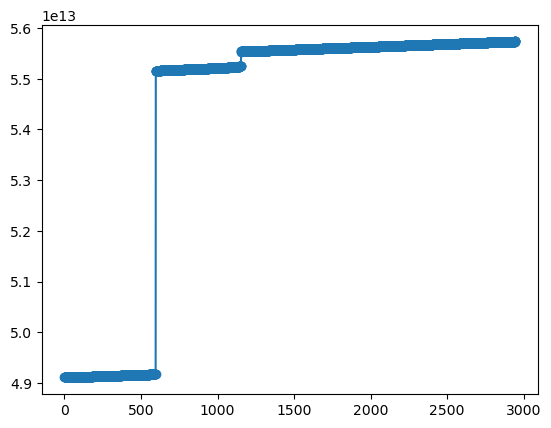

In [307]:
dft[(dft['user_id']==33) & (dft['activity']=='Jogging')]['time_stamp'].reset_index(drop=True).sort_values().plot(marker='o')

<Axes: xlabel='time_stamp'>

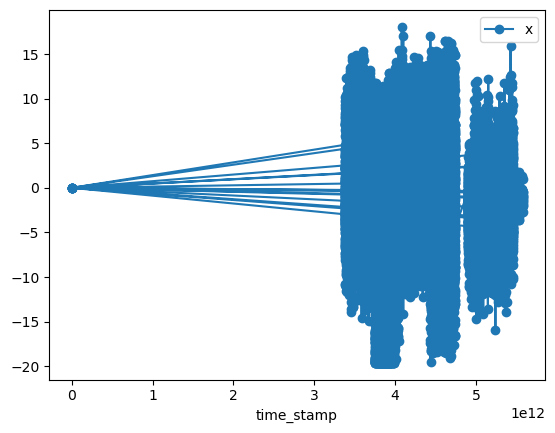

In [308]:
dft[(dft['user_id']==10)].plot(x='time_stamp', y='x', marker='o')


In [309]:
dft[(dft['user_id']==33) & (dft['activity']=='Downstairs')]['time_stamp'].reset_index(drop=True).sort_values().head()

2186    10338282268000
2187    10338332317000
2188    10338382243000
2189    10338432323000
2190    10338482249000
Name: time_stamp, dtype: int64

To get a better understanding of the data, we will visualize 15 seconds of the accelerometer data in each direction for each activity type. 

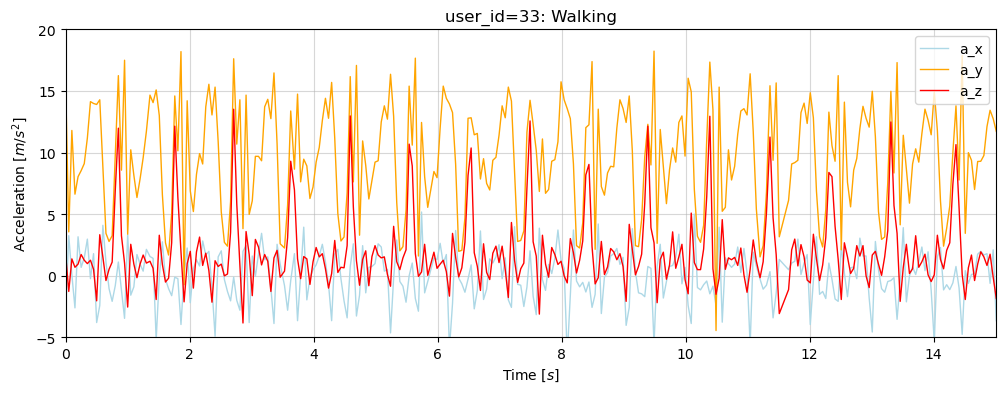

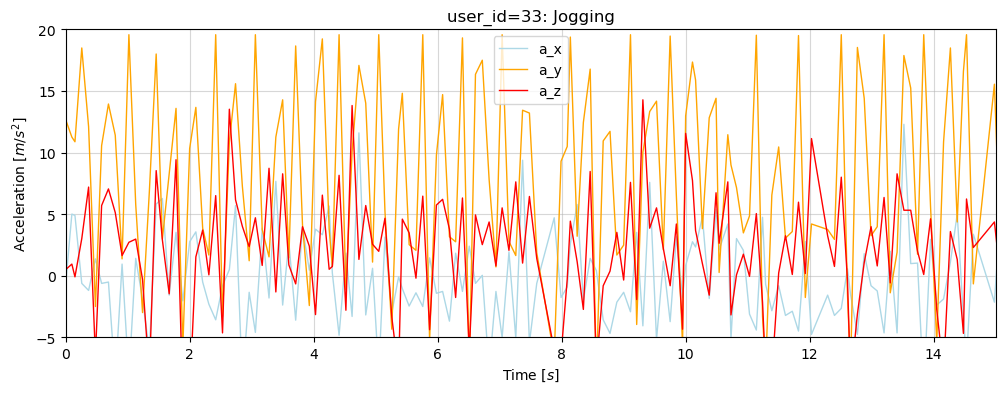

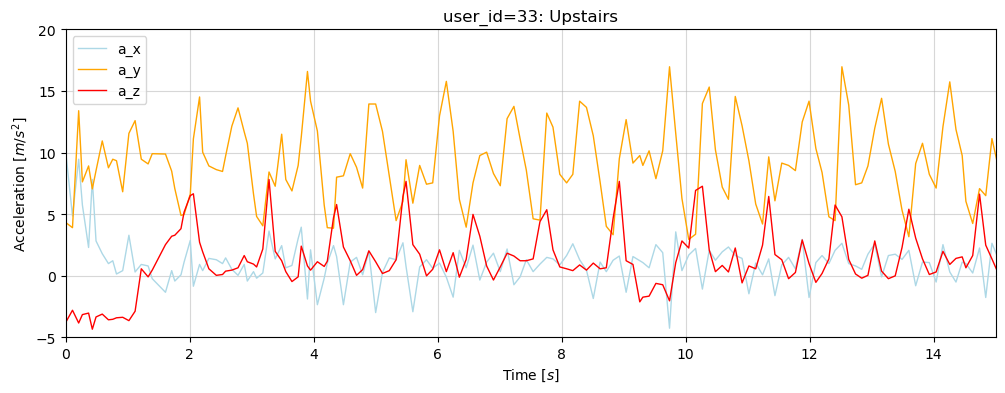

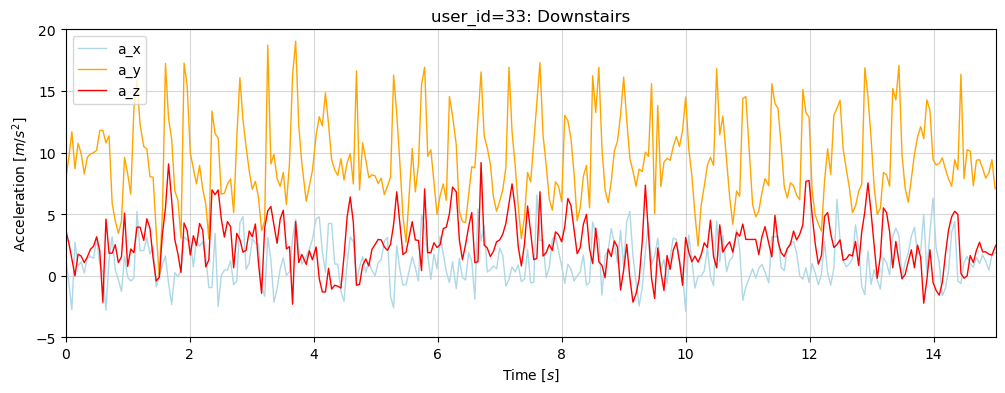

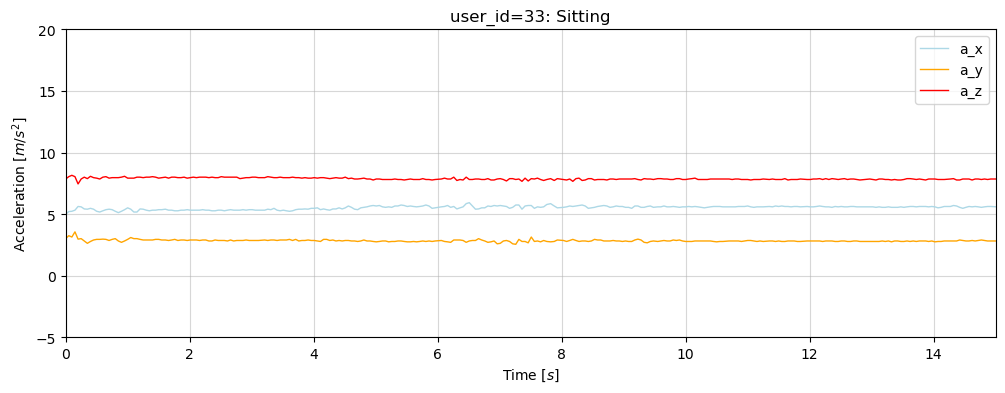

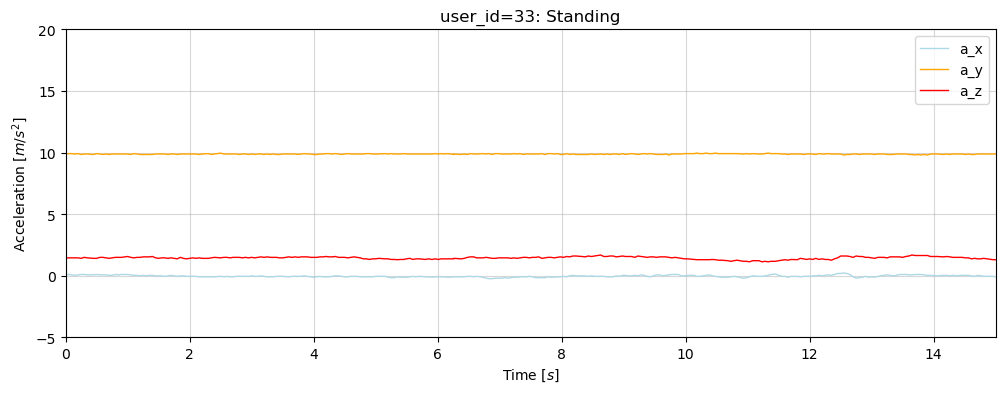

In [310]:
def plot_timehistory(activity_type):
    df_random_user = dft[(dft.user_id == 33) & (dft.activity ==activity_type)]
    df_random_user = df_random_user.sort_values(by='time_stamp')
    df_random_user.time_stamp = (df_random_user.time_stamp - df_random_user.time_stamp.min())/1E9 # seconds
    
    fig, ax = plt.subplots(figsize=(12,4))
    df_random_user.plot(x='time_stamp', y='x', ax=ax, label = 'a_x', linewidth=1, color='lightblue')
    df_random_user.plot(x='time_stamp', y='y', ax=ax, label = 'a_y', linewidth=1, color='orange')
    df_random_user.plot(x='time_stamp', y='z', ax=ax, label = 'a_z', linewidth=1, color='r')
    
    ax.set_xlim(0,15)
    ax.set_ylim(-5,20)
    ax.set_xlabel('Time [$s$]')
    ax.set_ylabel('Acceleration [$m/s^2$]')
    ax.set_title('user_id=33: '+activity_type)
    ax.grid(alpha=0.5)

for activity in dft['activity'].value_counts().index:
    plot_timehistory(activity)

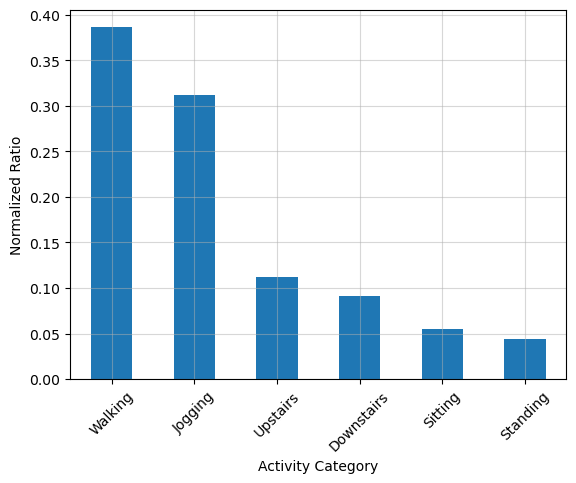

In [311]:
fig, ax = plt.subplots()
dft['activity'].value_counts(normalize=True).plot(kind='bar', ax=ax, rot=45)
ax.set_xlabel('Activity Category')
ax.set_ylabel('Normalized Ratio')
ax.grid(alpha=0.5)

**Summary:**
1. The data has 1098208 entries and 3 features (the three acceleration components).
2. The data is imbalanced (ranging from 38% in the walking category while only 4% in the standing category). We need to balance the data before using it for training a neural networks model.
3. Visualizations of 10 second of activity for subject 33 show that for walking, jogging, climbing up and down stairs contain, accelerometer data contains periodic patterns (as expected). However, for sitting and standing, no periodic patterns are observed. Also, for all activities except for sitting, the y component of the acceleration is in a range greater than the other two components. This can be attributed to the gravitational acceleration, g. While sitting, the motion is strictly against g so the range is different compared to other activities. 

## 3. Machine Learning Models

### Logistic Regression (Baseline Model)

Considering the unbalanced nature of the data, it's best practice to balance it before using logistic regression. However, in the original paper, this is not done so we will first make a logistic reression model using the processed data as is (without balancing it). Later on, we use the class_weights property to build another model that takes the imbalance in consideration. 

**Without Considering Class Imblanace:**

In [312]:
X = df.drop(columns = ['user', 'activity'])
X.shape
y = df['activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y) # stratify = y to preserve the original class proportions
print('Class distributions (training data):', Counter(y_train))
print('Class distributions (test data):', Counter(y_test))

Class distributions (training data): Counter({0: 1623, 1: 1289, 2: 470, 3: 406, 4: 107, 5: 60})
Class distributions (test data): Counter({0: 406, 1: 323, 2: 117, 3: 101, 4: 27, 5: 15})


In [313]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [314]:
model_lgr = LogisticRegression(multi_class = "multinomial", solver = 'lbfgs', max_iter = 150)
model_lgr.fit(X_train_scaled, y_train)
y_train_pred = model_lgr.predict(X_train_scaled) 
y_test_pred = model_lgr.predict(X_test_scaled)
print("TAINING ACCURACY:\n", round(accuracy_score(y_train, y_train_pred),2))
print("CLASSIFICATION REPORT TEST DATA (LOGISTIC REGRESSION):\n", classification_report(y_test, y_test_pred, target_names = activity_map.keys()))

c:\Users\setar\anaconda3\envs\my-learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


TAINING ACCURACY:
 0.81
CLASSIFICATION REPORT TEST DATA (LOGISTIC REGRESSION):
               precision    recall  f1-score   support

     Walking       0.74      0.95      0.83       406
     Jogging       0.96      0.98      0.97       323
    Upstairs       0.38      0.24      0.29       117
  Downstairs       0.50      0.12      0.19       101
     Sitting       0.96      1.00      0.98        27
    Standing       1.00      0.87      0.93        15

    accuracy                           0.79       989
   macro avg       0.76      0.69      0.70       989
weighted avg       0.75      0.79      0.75       989



We get an overall accuracy of 79%, which is close to the reported number (78.1%) in the original paper (see [Kwapisz et al., 2010](https://www.cis.fordham.edu/wisdm/includes/files/sensorKDD-2010.pdf), p.5, Table 2). 

**Note:** We note that the data is imbalanced and considering accuracy as a metric is not adviseable. However, this was just an attempt to reproduce the results from the original paper (which uses accuracy as the performance metric of their models). In the next subsection, we use a Logistic Regression model that considers class imbalance. It will be shown that the Logistic Regression model has an accuracy lower than what's reported in the original paper when class imbalance is considered. 

**Considering Class Imbalance:**

In [315]:
model_lgr_bl = LogisticRegression(multi_class = "multinomial", class_weight='balanced', solver = 'lbfgs', max_iter = 150)
model_lgr_bl.fit(X_train_scaled, y_train)

y_train_bl_pred = model_lgr_bl.predict(X_train_scaled)
y_test_bl_pred = model_lgr_bl.predict(X_test_scaled)

print("TAINING ACCURACY:\n", round(accuracy_score(y_train, y_train_bl_pred),2))
print("CLASSIFICATION REPORT (LOGISTIC REGRESSION):\n", classification_report(y_test, y_test_bl_pred, target_names = activity_map.keys()))

c:\Users\setar\anaconda3\envs\my-learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


TAINING ACCURACY:
 0.73
CLASSIFICATION REPORT (LOGISTIC REGRESSION):
               precision    recall  f1-score   support

     Walking       0.81      0.59      0.68       406
     Jogging       0.95      0.97      0.96       323
    Upstairs       0.31      0.46      0.37       117
  Downstairs       0.22      0.32      0.26       101
     Sitting       0.93      1.00      0.96        27
    Standing       1.00      0.87      0.93        15

    accuracy                           0.68       989
   macro avg       0.70      0.70      0.69       989
weighted avg       0.74      0.68      0.70       989



We can see that using balanced class weights improved the accuracy across categories that were underrepresented, but the overall performance actually deteriorates by ~14% (accuracy reduced from 0.79 to 0.68). There may be more we can explore with class imbalance to improve the performance of this model but since our goal was just to reproduce the results in the original paper, we leave that for now. 

**Summary:**

We have successfully reproduced the results for Logistic Regression in the original paper. We haven't conducted cross-validation, but since this is not the main method we'd like to implement, we suffice to the results we have. We can now use this as a baseline model. Can we use the raw time-series data to build a neural network model that outperforms this base model in terms of HAR accuracy?

### Neural Networks

Before using the time-series data to train a neural networks model, we need to do some cleaning as well as preprocessing:

1. As mentioned before, the data is imbalanced. We need to balance the data such that there's not a significant difference among the different classes. Alternatively, we can use class weights to adjust our neural network during the fitting process. 
2. A train-test split in this case must not be done in the conventional manner. In the conventional case, the data is shuffled randomly. However, with time-series data, we should not be using any data 
3. The data needs to be scaled since neural networks are sensitive to scaling. The scaling must be done after train-test split and before windowing. 
4. The time-series data in this format will not be usable by the model. We will use 10-second intervals to window the data and we will use an overlap of 4 seconds between windows. Note that the data was collected from multiple users so it cannot be merely ordered by time stamp as a whole. Instead, we need to consider each user's data (ordered by time stamp in ascending order), window it and eventually combine the windowed data for all users. We can alternatively change the time stamps for users such that the start time of a user i follows the end time of user j with a similar time increment used for data collection (50 ms). Since we're not interested in persolizing our HAR algorithm, this may be a good strategy. 

In [316]:
dft = dft.sort_values(by=['user_id', 'time_stamp']) # order the time series data by user_id then time_stamp in ascending order
dft.head()

,user_id,activity,time_stamp,x,y,z
941965,1,Walking,4991922345000,0.69,10.80,-2.03
941966,1,Walking,4991972333000,6.85,7.44,-0.50
941967,1,Walking,4992022351000,0.93,5.63,-0.50
941968,1,Walking,4992072339000,-2.11,5.01,-0.69
941969,1,Walking,4992122358000,-4.59,4.29,-1.95


In [317]:
dft['activity_label'] = dft['activity'].map(activity_map)
dft.head()

,user_id,activity,time_stamp,x,y,z,activity_label
941965,1,Walking,4991922345000,0.69,10.80,-2.03,0
941966,1,Walking,4991972333000,6.85,7.44,-0.50,0
941967,1,Walking,4992022351000,0.93,5.63,-0.50,0
941968,1,Walking,4992072339000,-2.11,5.01,-0.69,0
941969,1,Walking,4992122358000,-4.59,4.29,-1.95,0


#### Scaling and Windowing Transformer 

In [318]:
class ScalingAndWindowingTransformer:
    def __init__(self, scaler_type = 'standard', window_size = 100, step_size=50):
        if scaler_type=='standard':
            self.scaler = StandardScaler()
        elif scaler_type=='minmax':
            self.scaler = MinMaxScaler()
        else:
            raise Exception('Scaler type can be either standard or minmax.')
        self.window_size = window_size
        self.step_size = step_size
    
    def fit(self, df_X:pd.DataFrame)-> None:
        # fit scaler using all of training data (without breaking into users and/or activities)
        self.scaler.fit(df_X)
        #return self
        
    def transform(self, X:np.ndarray, y:np.ndarray, user_ids:np.ndarray, time_stamps: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        
        df = pd.DataFrame(X)
        df['user_id'] = user_ids
        df['activity_label'] = y
        df['timestamp'] = time_stamps

        X_windowed = []
        y_windowed = []
        t_windowed = []
        
        for (user_id, activity_label), group in df.groupby(['user_id', 'activity_label']):
            # sort each group by timestamp
            group = group.sort_values(by='timestamp')
            
            # store time stamps
            group_timestamps = group.timestamp.values
            group_dt_std = np.std(np.diff(group_timestamps))
            
            # drop non-feature columns
            X_user_activity = group.drop(columns=['user_id', 'activity_label', 'timestamp'])
            
            # scale each group using self.scaler
            X_scaled = self.scaler.transform(X_user_activity)

            # window the scaled data per user per activity
            i = 0
            # fig, ax = plt.subplots()
            
            while i <= X_scaled.shape[0] - self.window_size:
                window_timestamp = group_timestamps[i : i + self.window_size]
                
                # plt.show()
                
                dt_window = np.diff(window_timestamp)
                
                # print(np.median(dt_window))
                if np.all(dt_window < 3*50*1E6):
                    # ax.plot(window_timestamp,X_scaled[i : i + self.window_size, :])
                    # print('window admissible')
                    # t_windowed.append(window_timestamp)
                    X_windowed.append(X_scaled[i : i + self.window_size, :])
                    y_windowed.append(activity_label) #use the label for that specific activity
                i += self.window_size - self.step_size
                                    
        return np.array(X_windowed), np.array(y_windowed)

In [319]:
# test the transformer
def main(df):
    df_ex = dft[(dft.user_id==1) & (dft.activity=='Jogging')]
    X = df_ex[['x','y','z']].values
    y = df_ex['activity_label'].values
    user_ids = 1
    time_stamps = df_ex['time_stamp'].values

    dt = df_ex.sort_values(by='time_stamp')['time_stamp'].diff()
    display(dt.agg(['mean', 'median', 'max', 'std']).apply(lambda x: x/1E6))
    # dt.hist()
    tr = ScalingAndWindowingTransformer()
    tr.fit(X)
    tr.transform(X,y,user_ids,time_stamps)
    
if __name__=="__main__":
    main(df=dft)
    
    

mean          83.566711
median        49.988000
max       371120.056000
std         3529.210352
Name: time_stamp, dtype: float64

#### 1D Convolutional neural networks

In [320]:
def create_1d_cnn_model(input_shape, kernel_size=10, drop_out=0.25, alpha=0.0001):
    model = Sequential([
        Conv1D(filters=16, kernel_size=kernel_size, activation='relu', input_shape = input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(drop_out),

        Conv1D(filters=16, kernel_size=kernel_size, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(drop_out),

        Flatten(),
        Dense(16, activation='relu'),
        Dropout(drop_out),
        Dense(6, activation='softmax')  # For 6 classes
    ])

    model.compile(optimizer=Adam(learning_rate=alpha), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [321]:
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 0.40614089135346065,
 1: 0.5113783294543573,
 2: 1.4024822695035462,
 3: 1.6235632183908046,
 4: 6.160436137071651,
 5: 10.98611111111111}

### Splitting the data for train and test

There are different ways we can split train and test data. What's important is that: for the time-series of each individual, we shouldn't use information in later times to train a model and predict results for signal entries at prior times. This is what's called look-ahead bias. We need to control this for each individual's data independently. 

We can think of splitting the data for train and test sets in two ways:
1. Choose 20% of the data entries in a randomized fashion from the ending portion of some users' time series. 
2. Find the number of users that is 20% of all users (~6 in this case). Randomly choose 6 subjects and use their entire collected data as a test set. 

The latter seems more easier to implement so we will start with that. It's essential to make sure that the train and test data have more or less the same distribution in terms of class representation. 

In [322]:
user_list = dft['user_id'].unique()
n_test = int(0.2*len(user_list))
print(n_test)
random.seed(100)
test_users = random.sample(list(user_list), n_test)
print("LIST OF TEST USERS:\n", test_users)


7
LIST OF TEST USERS:
 [10, 30, 35, 12, 26, 24, 33]


In [323]:
dft_test = dft[dft['user_id'].isin(test_users)]
dft_test = dft_test.sort_values(by=['user_id', 'time_stamp'])
display(dft_test.head(10))
dft_test.shape

,user_id,activity,time_stamp,x,y,z,activity_label
400442,10,Walking,0,0.00,0.00,0.00,0
413091,10,Walking,0,0.00,0.00,0.00,0
426629,10,Downstairs,0,0.00,0.00,0.00,3
429525,10,Upstairs,0,0.00,0.00,0.00,2
430608,10,Downstairs,0,0.00,0.00,0.00,3
431570,10,Upstairs,0,0.00,0.00,0.00,2
432679,10,Downstairs,0,0.00,0.00,0.00,3
433665,10,Standing,0,0.00,0.00,0.00,5
400443,10,Walking,3378085705000,4.82,12.60,-2.87,0
400444,10,Walking,3378142376000,-1.42,9.53,2.30,0


(203020, 7)

In [324]:
dft_train = dft[~dft['user_id'].isin(test_users)]
dft_train.sort_values(by=['user_id', 'time_stamp'])
display(dft_train.head(10))
dft_train.shape

,user_id,activity,time_stamp,x,y,z,activity_label
941965,1,Walking,4991922345000,0.69,10.80,-2.03,0
941966,1,Walking,4991972333000,6.85,7.44,-0.50,0
941967,1,Walking,4992022351000,0.93,5.63,-0.50,0
941968,1,Walking,4992072339000,-2.11,5.01,-0.69,0
941969,1,Walking,4992122358000,-4.59,4.29,-1.95,0
941970,1,Walking,4992172376000,12.41,11.18,7.82,0
941971,1,Walking,4992222333000,17.27,11.60,5.94,0
941972,1,Walking,4992272321000,1.42,8.43,-5.28,0
941973,1,Walking,4992322339000,-2.68,15.89,-0.38,0
941974,1,Walking,4992372327000,-1.38,9.92,-1.99,0


(895188, 7)

In [325]:
print('train data class %:', dft_train['activity'].value_counts(normalize=True))
print('test data class %:', dft_test['activity'].value_counts(normalize=True))

train data class %: activity
Walking       0.387011
Jogging       0.310587
Upstairs      0.114861
Downstairs    0.087790
Sitting       0.056473
Standing      0.043277
Name: proportion, dtype: float64
test data class %: activity
Walking       0.383957
Jogging       0.315954
Downstairs    0.107566
Upstairs      0.098744
Standing      0.047552
Sitting       0.046227
Name: proportion, dtype: float64


The train and test data are representative of the entire dataset. Next, we will normalize the data. 

In [326]:
cv = GroupKFold(n_splits=5)
scores = []

user_ids = dft_train['user_id'].values
time_stamps = dft_train['time_stamp'].values
X = dft_train[['x','y','z']].values
y = dft_train['activity_label'].values

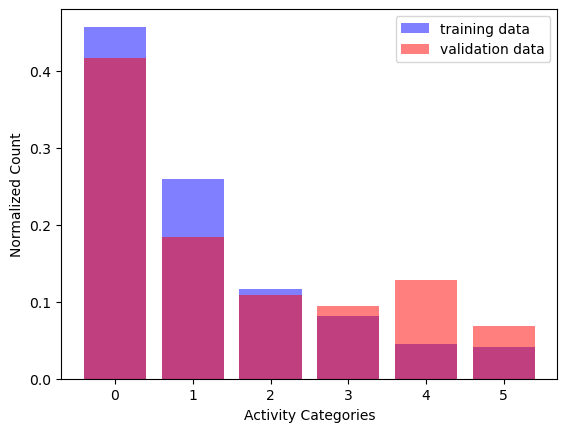

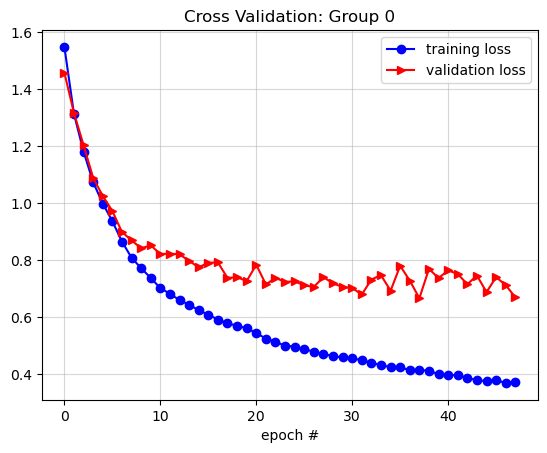

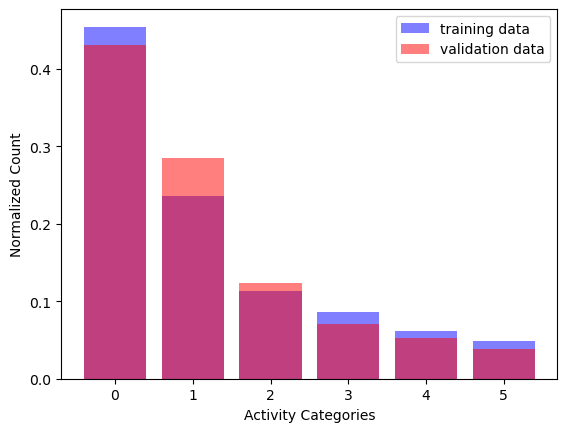

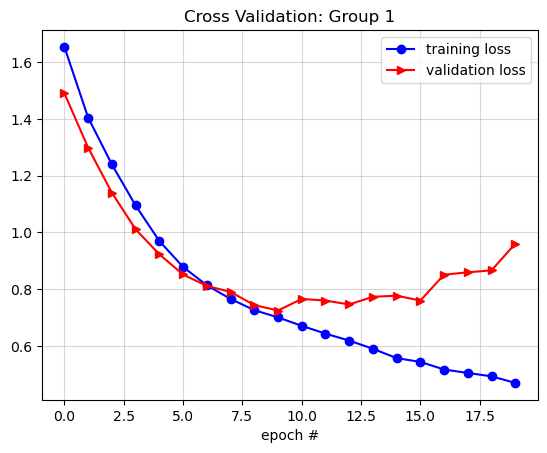

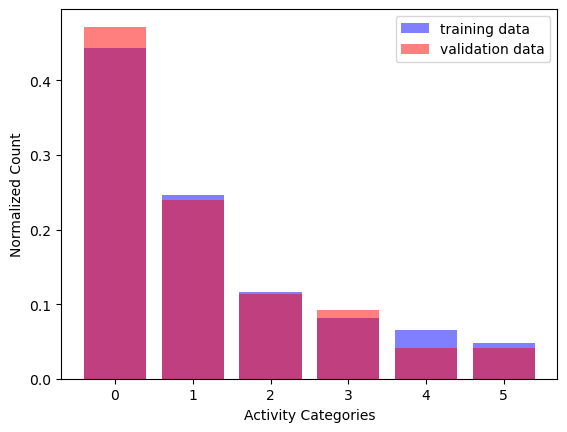

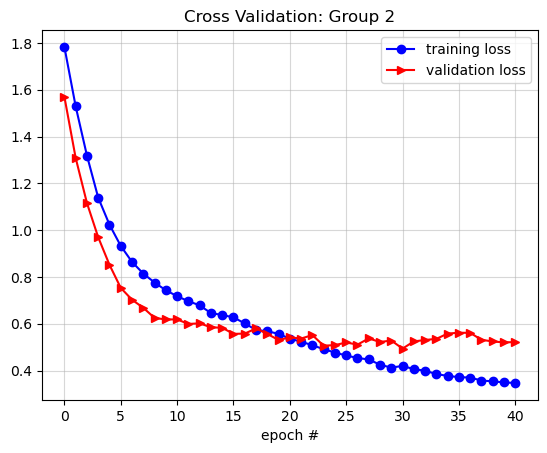

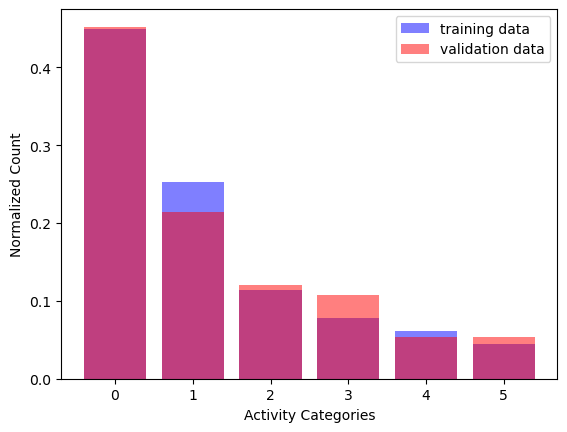

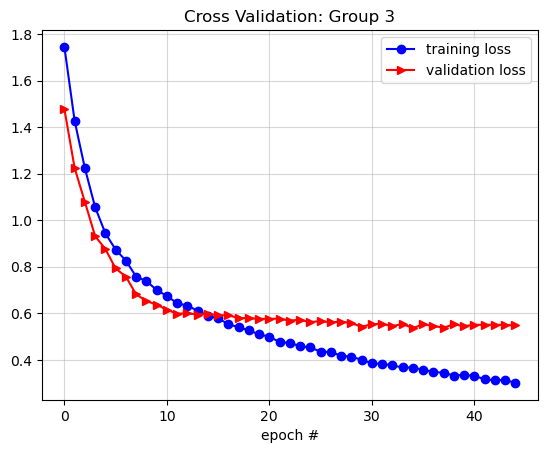

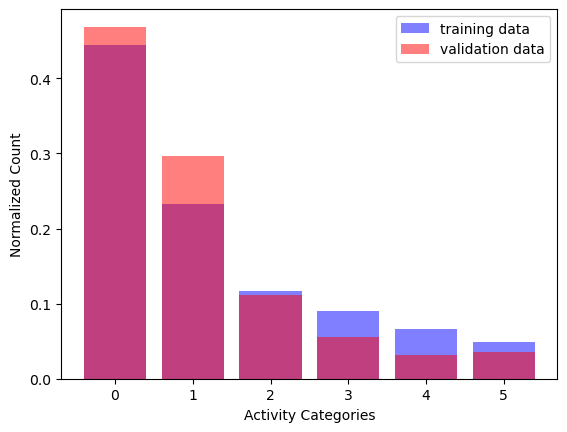

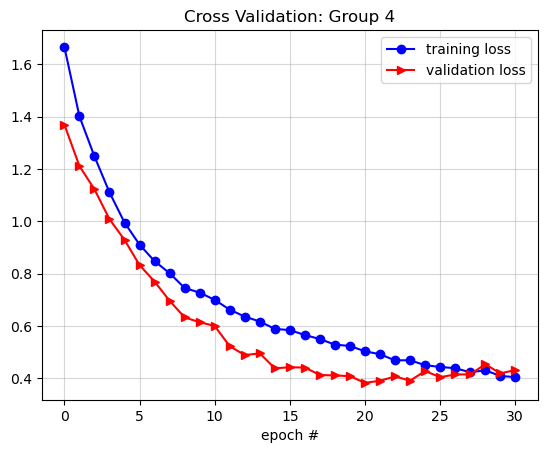

Mean cross-validation accuracy: 0.8


In [327]:
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y, groups=user_ids)):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]
    user_train_fold, user_val_fold = user_ids[train_idx], user_ids[val_idx]
    time_stamp_train_fold, time_stamp_val_fold = time_stamps[train_idx], time_stamps[val_idx]

    customer_transformer = ScalingAndWindowingTransformer()
    
    # fit on the training data
    customer_transformer.fit(X_train_fold)
    
    # window the data 
    X_train_windowed, y_train_windowed = customer_transformer.transform(X_train_fold, y_train_fold, user_train_fold, time_stamp_train_fold)
    X_val_windowed, y_val_windowed = customer_transformer.transform(X_val_fold, y_val_fold, user_val_fold, time_stamp_val_fold)

    # do train and validation follow the same distribution between classes?
    y_train_class_count = Counter(y_train_windowed)
    y_val_class_count = Counter(y_val_windowed)
    
    def normalize_counter(counts):
        total_sum = sum(counts.values())
        for key in counts:
            counts[key] = counts[key]/total_sum
        return counts
    
    fig, ax = plt.subplots(1,2)
    ax[0].bar(y_train_class_count.keys(), normalize_counter(y_train_class_count).values(), color='blue', label='training data', alpha=0.5)
    ax[0].bar(y_val_class_count.keys(), normalize_counter(y_val_class_count).values(), color='red', label='validation data', alpha=0.5)
    ax[0].set_xlabel('Activity Categories')
    ax[0].set_ylabel('Normalized Count')
    ax[0].legend()
    plt.show()

    # define the 1d-cnn model
    model = create_1d_cnn_model(input_shape=X_train_windowed.shape[1:])
    
    # determine class weights to address imbalance
    class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train_windowed), 
    y=y_train_windowed
)
    class_weights_dict = dict(enumerate(class_weights))
    
    # leverage early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # train model with train fold data and use val fold for validation
    history = model.fit(
    X_train_windowed,
    y_train_windowed,
    shuffle = True,
    epochs=50,
    validation_data=(X_val_windowed, y_val_windowed),
    class_weight=class_weights_dict,
    callbacks = [early_stopping],
    verbose = 0
    )

    # plot loss and validation loss to get a sense of how the model is behaving
    # fig, ax = plt.subplots()
    ax[1].plot(history.history['loss'], color='blue', marker='o' ,label='training loss')
    ax[1].plot(history.history['val_loss'], color='red', marker='>' ,label='validation loss')
    ax[1].set_xlabel('epoch #')
    ax[1].legend()
    ax[1].set_title(f'Cross Validation: Group {fold}')
    ax[1].grid(alpha=0.5)
    plt.show()

    # get the best validation accuracy
    best_val_acc = history.history['val_accuracy'][-1]

    # append the best validation accuracy to scores
    scores.append(best_val_acc)

# determine mean best validation accuracy
print('Mean cross-validation accuracy:', round(np.mean(scores),2))    


In [328]:
user_ids_test = dft_test['user_id'].values
time_stamps_test = dft_test['time_stamp'].values
X_test = dft_test[['x','y','z']].values
y_test = dft_test['activity_label'].values


In [329]:
customer_transformer = ScalingAndWindowingTransformer()
    # fit on the full training data set
customer_transformer.fit(X)
    
# window the data 
X_train_windowed, y_train_windowed = customer_transformer.transform(X, y, user_ids, time_stamps)
X_test_windowed, y_test_windowed = customer_transformer.transform(X_test, y_test, user_ids_test, time_stamps_test)

# define the 1d-cnn model
model_cnn = create_1d_cnn_model(input_shape = X_train_windowed.shape[1:])

# determine class weights to address imbalance
class_weights = compute_class_weight(
class_weight='balanced', 
classes=np.unique(y_train_windowed), 
y=y_train_windowed
)
class_weights_dict = dict(enumerate(class_weights))

# leverage early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# train model with train fold data and use val fold for validation
history = model_cnn.fit(
X_train_windowed,
y_train_windowed,
shuffle = True,
epochs=50,
class_weight=class_weights_dict
)

Epoch 1/50
426/426 [==============================] - 6s 10ms/step - loss: 1.5914 - accuracy: 0.2973
Epoch 2/50
426/426 [==============================] - 379s 892ms/step - loss: 1.3577 - accuracy: 0.3314
Epoch 3/50
426/426 [==============================] - 4s 11ms/step - loss: 1.1803 - accuracy: 0.4233
Epoch 4/50
426/426 [==============================] - 3s 7ms/step - loss: 1.0238 - accuracy: 0.5057
Epoch 5/50
426/426 [==============================] - 3s 7ms/step - loss: 0.9328 - accuracy: 0.5480
Epoch 6/50
426/426 [==============================] - 3s 7ms/step - loss: 0.8501 - accuracy: 0.6027
Epoch 7/50
426/426 [==============================] - 3s 7ms/step - loss: 0.8062 - accuracy: 0.6352
Epoch 8/50
426/426 [==============================] - 3s 7ms/step - loss: 0.7569 - accuracy: 0.6744
Epoch 9/50
426/426 [==============================] - 3s 7ms/step - loss: 0.7189 - accuracy: 0.6996
Epoch 10/50
426/426 [==============================] - 3s 8ms/step - loss: 0.6915 - accuracy: 

In [330]:
test_loss, test_acc = history.model.evaluate(X_test_windowed, y_test_windowed)
print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")

108/108 [==============================] - 1s 4ms/step - loss: 0.5366 - accuracy: 0.8383
Test Accuracy: 0.8383163809776306, Test Loss: 0.5365725159645081


### Windowing the Data

In this section, we apply 10-second windows to each subject's data and combine samples for all. Each windowed sample will inherit the label of the majority. Why 10 seconds? The original paper has a discussion on what window length gave them the best feature engineering performance in terms of detecting peaks, etc. Therefore, we also assume that a 10-second window is long enough to capture the main properties of the signal and short enough so that we don't reduce the data to a very small dataset. 

Let's plot one of the windowed samples for training and test sets:

### Multilayer perceptron

## 4. Results and Recommendations

## 5. Limitations and Next Steps